In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
import astropy
import gammapy

from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator, LightCurveEstimator, ESTIMATOR_REGISTRY
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

print(MODEL_REGISTRY)

Registry
--------

SkyModel          : ['SkyModel', 'sky-model'] 
FoVBackgroundModel: ['FoVBackgroundModel', 'fov-bkg'] 
BackgroundModel   : BackgroundModel 

CPU times: user 2.3 s, sys: 1.04 s, total: 3.34 s
Wall time: 5.49 s


In [2]:
source = "1ES1959"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str36
37793,events,events,37793.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/1ES1959
37793,gti,gti,37793.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/1ES1959
37793,aeff,aeff_2d,37793.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/1ES1959
37793,edisp,edisp_2d,37793.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/1ES1959
37793,psf,psf_table,37793.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/1ES1959
37793,bkg,bkg_2d,37793.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/1ES1959
37890,events,events,37890.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/1ES1959
37890,gti,gti,37890.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/1ES1959
37890,aeff,aeff_2d,37890.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/1ES1959


In [3]:

data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]



# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)
print(len(observations))

110


In [5]:
target_position = SkyCoord(ra="19h59m59.8s",dec="+65d08m55s", frame="icrs")
#print(target_position)-> In (299.99916667, 65.14861111)


on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fc3f864fac8>)

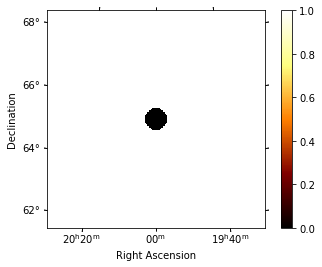

In [7]:
energy_axis = MapAxis.from_energy_bounds(0.350, 15, 10, unit= "TeV", name="energy")


true_energy_axis = MapAxis.from_energy_bounds(0.100, 25, 15, unit= "TeV", name="energy_true")


geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
geom_image = geom.to_image()
# IS THERE AN EXCLUSION REGION ASIDE FROM THE CENTER???
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
#region_extra = CircleSkyRegion(center=SkyCoord(ra="05h37m38.686s", dec= "+21d08m33.18s", frame="icrs"), radius=0.25*u.deg)
exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region, region_extra], inside=False)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [9]:
%time
e_reco = energy_axis
e_true = true_energy_axis
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)
# Create the DatasetMaker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])
# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

#Create a Safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)




CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs


In [10]:
%time
# Create a stacked dataset
stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region, name= "1ES 1959+650")
list_of_dataset = Datasets()
count = 0
for obs in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    list_of_dataset.append(dataset)
    stacked.stack(dataset)
    count+=1
    print(dataset)
# Making sure all the datasets are in the list
print(count==len(observations))




CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
SpectrumDatasetOnOff
--------------------

  Name                            : 37793 

  Total counts                    : 8 
  Total off counts                : 89.00
  Total background counts         : 6.85
  Total excess counts             : 1.15

  Predicted counts                : 6.93
  Predicted background counts     : 6.93
  Predicted excess counts         : nan

  Exposure min                    : 1.43e+00 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 37890 

 

SpectrumDatasetOnOff
--------------------

  Name                            : 41960 

  Total counts                    : 3 
  Total off counts                : 46.00
  Total background counts         : 3.54
  Total excess counts             : -0.54

  Predicted counts                : 3.50
  Predicted background counts     : 3.50
  Predicted excess counts         : nan

  Exposure min                    : 5.18e+02 m2 s
  Exposure max                    : 1.43e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 41961 

  Total counts                    : 4 
  Total off counts           

SpectrumDatasetOnOff
--------------------

  Name                            : 53471 

  Total counts                    : 6 
  Total off counts                : 62.00
  Total background counts         : 4.77
  Total excess counts             : 1.23

  Predicted counts                : 4.86
  Predicted background counts     : 4.86
  Predicted excess counts         : nan

  Exposure min                    : 1.29e+00 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 53472 

  Total counts                    : 6 
  Total off counts            

SpectrumDatasetOnOff
--------------------

  Name                            : 58026 

  Total counts                    : 13 
  Total off counts                : 32.00
  Total background counts         : 2.46
  Total excess counts             : 10.54

  Predicted counts                : 3.21
  Predicted background counts     : 3.21
  Predicted excess counts         : nan

  Exposure min                    : 1.07e+03 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 22.22

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 58279 

  Total counts                    : 5 
  Total off counts         

SpectrumDatasetOnOff
--------------------

  Name                            : 62082 

  Total counts                    : 0 
  Total off counts                : 24.00
  Total background counts         : 1.85
  Total excess counts             : -1.85

  Predicted counts                : 1.71
  Predicted background counts     : 1.71
  Predicted excess counts         : nan

  Exposure min                    : 3.41e+00 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 62109 

  Total counts                    : 2 
  Total off counts           

SpectrumDatasetOnOff
--------------------

  Name                            : 62677 

  Total counts                    : 3 
  Total off counts                : 12.00
  Total background counts         : 0.92
  Total excess counts             : 2.08

  Predicted counts                : 1.07
  Predicted background counts     : 1.07
  Predicted excess counts         : nan

  Exposure min                    : 5.11e+02 m2 s
  Exposure max                    : 1.16e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 62695 

  Total counts                    : 7 
  Total off counts            

SpectrumDatasetOnOff
--------------------

  Name                            : 62993 

  Total counts                    : 11 
  Total off counts                : 28.00
  Total background counts         : 2.15
  Total excess counts             : 8.85

  Predicted counts                : 2.79
  Predicted background counts     : 2.79
  Predicted excess counts         : nan

  Exposure min                    : 2.61e+04 m2 s
  Exposure max                    : 2.94e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 62994 

  Total counts                    : 5 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 64518 

  Total counts                    : 5 
  Total off counts                : 67.00
  Total background counts         : 5.15
  Total excess counts             : -0.15

  Predicted counts                : 5.14
  Predicted background counts     : 5.14
  Predicted excess counts         : nan

  Exposure min                    : 2.41e+05 m2 s
  Exposure max                    : 2.83e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 64643 

  Total counts                    : 29 
  Total off counts          

SpectrumDatasetOnOff
--------------------

  Name                            : 77945 

  Total counts                    : 20 
  Total off counts                : 44.00
  Total background counts         : 3.38
  Total excess counts             : 16.62

  Predicted counts                : 4.57
  Predicted background counts     : 4.57
  Predicted excess counts         : nan

  Exposure min                    : 5.36e+04 m2 s
  Exposure max                    : 4.35e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 37.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 78168 

  Total counts                    : 16 
  Total off counts        

SpectrumDatasetOnOff
--------------------

  Name                            : 78613 

  Total counts                    : 85 
  Total off counts                : 84.00
  Total background counts         : 6.46
  Total excess counts             : 78.54

  Predicted counts                : 12.07
  Predicted background counts     : 12.07
  Predicted excess counts         : nan

  Exposure min                    : 1.14e+05 m2 s
  Exposure max                    : 6.51e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 235.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 78614 

  Total counts                    : 93 
  Total off counts     

SpectrumDatasetOnOff
--------------------

  Name                            : 79008 

  Total counts                    : 78 
  Total off counts                : 78.00
  Total background counts         : 6.00
  Total excess counts             : 72.00

  Predicted counts                : 11.14
  Predicted background counts     : 11.14
  Predicted excess counts         : nan

  Exposure min                    : 7.25e+03 m2 s
  Exposure max                    : 6.09e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 235.34

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 79009 

  Total counts                    : 12 
  Total off counts     

In [9]:
print(list_of_dataset.gti)

GTI info:
- Number of GTIs: 110
- Duration: 135259.31781968474 s
- Start: 54414.12966745328 MET
- Start: 2007-11-10T03:06:43.268 (time standard: TT)
- Stop: 57552.34818470555 MET
- Stop: 2016-06-13T08:21:23.159 (time standard: TT)



In [11]:
print(stacked)
print(stacked.info_dict())

SpectrumDatasetOnOff
--------------------

  Name                            : 1ES 1959+650 

  Total counts                    : 1927 
  Total off counts                : 5111.00
  Total background counts         : 393.15
  Total excess counts             : 1533.85

  Predicted counts                : 502.71
  Predicted background counts     : 502.71
  Predicted excess counts         : nan

  Exposure min                    : 8.13e+10 cm2 s
  Exposure max                    : 3.11e+14 cm2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 130.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2944.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


{'name': '1ES 1959+650', 'counts': 1927.0, 'background': 393.15384, 'excess': 1533.8462, 'sqrt_ts': 51.63166300316968, 'npred': 50

In [12]:



info_table= list_of_dataset.info_table(cumulative=True)
info_table



name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
37793,8.0,6.846153846153847,1.1538461538461533,0.4129709030290072,6.92857142857143,6.92857142857143,nan,1.4278769248052066,226715841.4221925,1093.0654237029983,1202.5660500079393,0.007318866580646426,0.006263260823822423,0.0010556057568240032,10,10,wstat,6.429436383455192,89.0,10.0,130.0,0.07692307692307691
37793,23.0,14.000000953674316,8.999999046325684,2.1045221231063023,14.642857649382583,14.642857649382583,nan,574.5225528321342,384783680.25230694,2168.460602916177,2405.147428229451,0.010606602660463036,0.00645619336355335,0.004150409296909686,10,10,wstat,7.536094515819507,182.0,10.0,129.99998474121094,0.07692307978868484
37793,26.0,17.69230842590332,8.30769157409668,1.7684168807715093,18.285714918253372,18.285714918253372,nan,595.4531523614686,549988112.215892,3345.9585266860786,3607.5524532943964,0.0077705685209885295,0.0052876651891517095,0.002482903331836819,10,10,wstat,8.088350124401993,230.0,10.0,130.0,0.07692307978868484
37793,37.0,21.923078536987305,15.076921463012695,2.8013114290031242,23.00000079561557,23.00000079561557,nan,609.1532642125026,732471432.2691851,4522.258858106325,4810.070889905095,0.00818175189898209,0.004847815931122415,0.0033339359678596745,10,10,wstat,13.34285459559469,285.0,10.0,129.99998474121094,0.07692307978868484
37793,52.0,25.923080444335938,26.076919555664062,4.2908322586216086,27.785716146268697,27.785716146268697,nan,609.775104755919,941597718.6368074,5675.739276171452,6012.522428244352,0.009161802096567832,0.004567348707007954,0.004594453389559879,10,10,wstat,28.445742640848945,337.0,10.0,129.99998474121094,0.07692308723926544
37793,65.0,30.230770111083984,34.769229888916016,5.215251089297061,32.71428684593768,32.71428684593768,nan,610.0345731416954,1176879478.6838012,6828.913561825181,7215.058921992779,0.009518351552047949,0.004426878424714477,0.005091473127333472,10,10,wstat,36.25208028285784,393.0,10.0,130.0,0.07692307978868484
37793,74.0,32.0,42.0,6.021029958257814,35.00000121071935,35.00000121071935,nan,1084.4886503556118,1250626987.7414134,7943.113749888655,8417.30940592289,0.009316245785985038,0.004028646826371909,0.00528759895961313,10,10,wstat,48.410083916575296,416.0,10.0,130.0,0.07692307978868484
37793,79.0,34.61538314819336,44.38461685180664,6.13661586043119,37.785715592797004,37.785715592797004,nan,1196.7005628738323,1331663710.991279,9073.336553425786,9619.63521194458,0.008706830120852539,0.003815066590373941,0.004891763530478598,10,10,wstat,50.334336592312596,450.0,10.0,130.0,0.07692307978868484


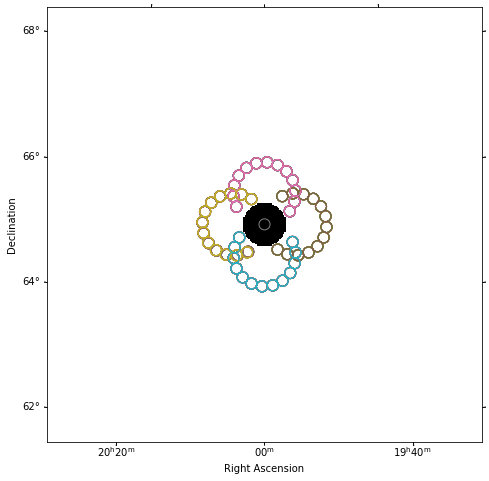

In [22]:
plt.figure(figsize=(8,8))
_, ax, _ = exclusion_mask.plot()

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="grey")
plot_spectrum_datasets_off_regions(ax=ax, datasets=list_of_dataset)

Note that there is another option to SkyModel, which is the temporal model. See **doc 13** for info about this. But in short the temporal model is a model where you want to stimulate a flaring episode (like for instance stimulating the exponential decay of a flares, which can be useful).

See -> (gammapy.modeling.models.TemporalModel)

In [13]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.50, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")

joint_model = sky_model


for dataset in list_of_dataset:
    dataset.models = joint_model
    
    
# Performing a joint fit of the model:
joint_fit = Fit(list_of_dataset)
result_joint = joint_fit.run()
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.4518e+00,,nan,nan,False,5.125e-02
amplitude,2.1508e-12,cm-2 s-1 TeV-1,nan,nan,False,7.164e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


The stacked dataset

In [14]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.5, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")

stacked_model = sky_model
stacked.models = stacked_model
  
  
# Performing a joint fit of the model:
stacked_fit = Fit(stacked)
result_stacked = stacked_fit.run()
result_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.4530e+00,,nan,nan,False,4.566e-02
amplitude,2.3092e-12,cm-2 s-1 TeV-1,nan,nan,False,6.938e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff2f04e0d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2f089a5f8>)

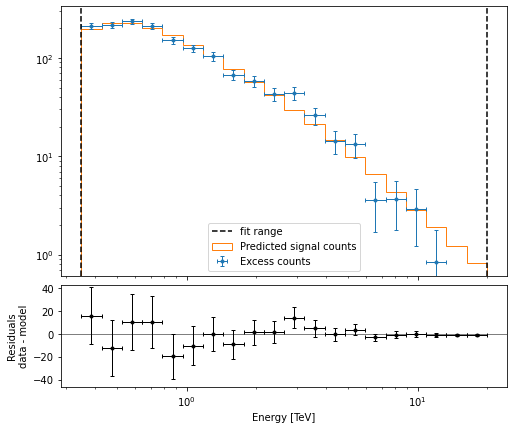

In [25]:
stacked.plot_fit()

Compare Stacked and Joint spectral fit

In [15]:
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[0.15, 35]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)

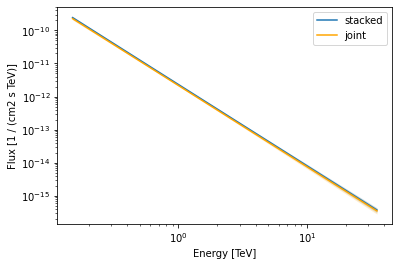

In [16]:
plot_spectrum(model=stacked_model, result=result_stacked, label="stacked", color="tab:blue")
plot_spectrum(model=joint_model, result=result_joint, label="joint", color="orange")
plt.legend()




In [17]:
from astropy.io import fits
from astropy.table import Table
hdul = fits.open("/Users/cedrickperron/GAMMAPY/1ES1959/1ES1959.fits")
spectrum = Table.read(hdul[1])
lightcurve = Table.read(hdul[3])
spectrum

E,dNdE,dNdE_errl,dNdE_erru,dNdE_ul,Hz,nuFnu,nuFnu_errl,nuFnu_erru,nuFnu_ul,Sigma
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),Hz,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.39810717055349704,9.289101348490516e-11,5.5558477009081816e-12,5.712603562955816e-12,0.0,9.626188555952215e+25,2.358761850005943e-11,1.4107846507105884e-12,1.450589335070377e-12,0.0,0.0
0.6309573444801928,3.93912961035587e-11,1.5140465002640263e-12,1.5462459782550277e-12,0.0,1.5256480711675739e+26,2.5125265779698602e-11,9.657164014595467e-13,9.862544523113025e-13,0.0,0.0
0.9999999999999992,1.1322550027242778e-11,5.162185338103425e-13,5.302381428963406e-13,0.0,2.417989242084916e+26,1.814072509094441e-11,8.270732729086682e-13,8.495351630040685e-13,0.0,0.0
1.584893192461112,3.0321840502486603e-12,1.843670817649455e-13,1.9145998496653735e-13,0.0,3.83225468922459e+26,1.2202981495011905e-11,7.419826929313462e-13,7.705279807768639e-13,0.0,0.0
2.5118864315095766,9.371011122583764e-13,7.294651280217328e-14,7.662160775229732e-14,0.0,6.0737143687292305e+26,9.473203070702287e-12,7.374200286767344e-13,7.745717514857436e-13,0.0,0.0
3.9810717055349683,2.474723218127212e-13,2.6918126382864777e-14,2.891616079058251e-14,0.0,9.626188555952209e+26,6.284012303505504e-12,6.835262874579096e-13,7.342619523959355e-13,0.0,0.0
6.309573444801928,4.897301864023439e-14,8.78071550650933e-15,9.903823695694623e-15,0.0,1.5256480711675738e+27,3.1236852581219342e-12,5.600674074216021e-13,6.317035162677062e-13,0.0,0.0
9.999999999999988,6.62638989351762e-15,2.2601656820974776e-15,2.902455652600659e-15,0.0,2.4179892420849147e+27,1.061664705516765e-12,3.6211846448252413e-13,4.650246627817984e-13,0.0,0.0


A Spectral Model computes the flux as a fct of energy. So we want to compute the flux points with FluxPointsEstimator (**see doc #9**). To do this, we first need to defined the fixed energy binning. Then, we run it for the list_of_dataset. Then, we can check at the table_formatted. Then, we plot the flux_points and their likelihood profiles (which is like you assign a color depending on the TS significance of the runs). We also need to define the significance (TS) threshold (both as an upper-limit and as a lower-limit).

In [18]:
%%time
# Defining the energy edges
energy_edges = list(spectrum["E"])*u.TeV
print(energy_edges)

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=source)

flux_points_joint = fpe.run(datasets=list_of_dataset)



[ 0.39810717  0.63095734  1.          1.58489319  2.51188643  3.98107171
  6.30957344 10.         15.84893192] TeV
CPU times: user 9min 37s, sys: 5.07 s, total: 9min 42s
Wall time: 9min 59s


In [19]:
flux_points_joint.table

counts [110],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4 .. 123,0.5096480487725894,0.3499999999999999,0.742117524622022,1.1228287526362033e-11,4.5174095949273795e-12,2.2024723211652966e-12,2.916448130682841e-12,1.005536013210076,1097.664262987617,True,0.044802869149875676,979.2425260520658,0.04525145793400419,0.04435792664962312,1.0969601590786038,0.20000000000000004 .. 5.000000000000001,1618.782285929024 .. 4139.444223371973,31.292851037450482,1.1290447474434504e-11,1.2316984071098398e-11,5.030594968207794e-13,5.080963806700755e-13,4.980635544952452e-13
2 .. 63,0.8955170275417836,0.742117524622022,1.080624995381593,2.819106811542934e-12,9.60505686448066e-13,8.505946938465744e-13,2.2607848123106923e-12,0.9841392024245579,511.27024533123927,True,0.06636455668693626,480.26043909680686,0.06748062195354985,0.0652799574145126,1.1215251313770036,0.20000000000000004 .. 5.000000000000001,752.9386788104114 .. 1788.474240783048,21.914845176199783,2.7743935290615015e-12,3.161699137181495e-12,1.870887738011692e-13,1.9023508099640605e-13,1.8403117260448514e-13
1 .. 29,1.3039957306551409,1.080624995381593,1.5735383438603354,1.1219586935155872e-12,5.56631268467499e-13,7.17782142195847e-13,1.9077840214189135e-12,1.0185537706856849,374.4772761364101,True,0.08071047180616121,359.0402979301901,0.08251578738670835,0.07897166891829939,1.1874996483115041,0.20000000000000004 .. 5.000000000000001,557.3452406311465 .. 1191.827596961389,18.94835871336064,1.142775257833886e-12,1.3323255539697945e-12,9.055381550066728e-14,9.257930501080127e-14,8.860295048432069e-14
0 .. 27,1.8987967992462276,1.5735383438603354,2.29128784747792,4.465213254074081e-13,3.225783807501587e-13,6.057070510578466e-13,1.6099010629239566e-12,0.9630549739085836,309.04261505610276,True,0.10798702728097372,192.0099975378954,0.11100040057560026,0.10499670931354314,1.1911307239664568,0.20000000000000004 .. 5.000000000000001,402.3123787163897 .. 790.1432766175176,13.856767210929663,4.300245833898576e-13,5.318652695989878e-13,4.821851054830632e-14,4.956404598577026e-14,4.688326980609964e-14
0 .. 25,2.764908810718509,2.29128784747792,3.336429658981338,1.777082304330115e-13,1.8694029175522328e-13,5.111314563759212e-13,1.3585297933652097e-12,1.107411479606526,262.21430260747684,True,0.17136137491548406,95.06900963677856,0.1780905160921654,0.1644840382231557,1.469939920065995,0.20000000000000004 .. 5.000000000000001,313.7866106070431 .. 494.26519605884596,9.750333821812388,1.9679613440207872e-13,2.6122042203777037e-13,3.0452326700798516e-14,3.164815047164047e-14,2.923016736711282e-14
1 .. 15,4.858299615905243,3.336429658981338,7.074351198853508,4.461753243357323e-14,1.7111789202056254e-13,7.952988229756992e-13,1.0531109713898943e-12,1.0233073251147289,215.0132547813593,True,0.17552640832083313,55.537695452910555,0.18505607378898703,0.1758883812081185,1.410488699975221,0.20000000000000004 .. 5.000000000000001,248.860699452819 .. 416.3623301561544,7.4523617365846215,4.565744776781948e-14,6.293252531833298e-14,7.831555216203391e-15,8.25674537430985e-15,7.84770555324192e-15
0 .. 2,8.536655916609186,7.074351198853508,10.301226528079198,1.1202205973298347e-14,3.63836187277144e-14,3.0714436333421936e-13,8.163550946605016e-13,0.005692346501746215,32.40978882969553,False,0.02528810910653638,-2.115277520431391e-05,0.005333327775588259,0.005621087892386356,1.652458225256183,0.20000000000000004 .. 5.000000000000001,32.41051087746817 .. 71.31012179557143,nan,6.37668379839454e-17,1.85111774015908e-14,2.8328260688666

In [ ]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_joint["is_ul"] = flux_points_joint.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_joint.to_sed_type("dnde").plot_ts_profiles(ax=ax);

'\n# Same Plot as above, but lacking some error bar\nplt.figure(figsize=(8,8))\nflux_data = list(flux_points_joint.table["dnde"])\nenergy_data = list(flux_points_joint.table["e_ref"])\nflux_error = list(flux_points_joint.table["dnde_errp"])\n\nplt.errorbar(x=energy_data, y=flux_data, yerr=flux_error, fmt= "o", label="Gam Data", color="blue")\nplt.errorbar(list(spectrum["E"]), list(spectrum["dNdE"]), xerr=list(spectrum["dNdE_errl"]), yerr=list(spectrum["dNdE_erru"]), fmt="o",label="EventDisplay", color="orange")\nplot_spectrum(model=joint_model , result=result_joint, label="joint", color="orange")\n\n# DEFINIE THE AXIS BOUNDARY WITH plt (not ax)\nplt.axis([0.30, 16, 1e-15, 1e-9])\n#plt.set_ylim([10e-5, 10])\nplt.legend()\n'

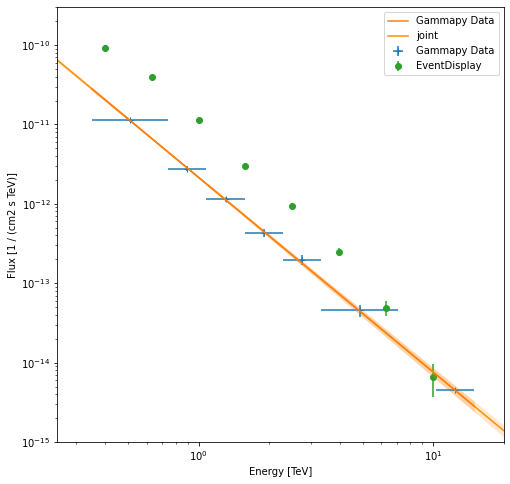

In [20]:
plt.figure(figsize=(8,8))
# Final Plot with the best-fit model, the flux points and residuals

"""
ax_spectrum = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Gammapy Data")
"""
# Below is the same thing as above, but with the dataset, you've got a bigger range of plot. Like the residuals plot next run box
flux_points_joint_dataset= FluxPointsDataset(data=flux_points_joint,models=joint_model)
ax_spectrum = flux_points_joint_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label="Gammapy Data");


# The Joint fit
plot_spectrum(ax=ax_spectrum,model=joint_model , result=result_joint, label="joint", color="darkorange")


# For the ED DATA
ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

# # DEFINIE THE AXIS BOUNDARY WITH ax (not plt)
ax_spectrum.set_xlim([0.25, 20])
ax_spectrum.set_ylim([1e-15, 3e-10])

plt.legend()
"""
# Same Plot as above, but lacking some error bar
plt.figure(figsize=(8,8))
flux_data = list(flux_points_joint.table["dnde"])
energy_data = list(flux_points_joint.table["e_ref"])
flux_error = list(flux_points_joint.table["dnde_errp"])

plt.errorbar(x=energy_data, y=flux_data, yerr=flux_error, fmt= "o", label="Gam Data", color="blue")
plt.errorbar(list(spectrum["E"]), list(spectrum["dNdE"]), xerr=list(spectrum["dNdE_errl"]), yerr=list(spectrum["dNdE_erru"]), fmt="o",label="EventDisplay", color="orange")
plot_spectrum(model=joint_model , result=result_joint, label="joint", color="orange")

# DEFINIE THE AXIS BOUNDARY WITH plt (not ax)
plt.axis([0.30, 16, 1e-15, 1e-9])
#plt.set_ylim([10e-5, 10])
plt.legend()
"""

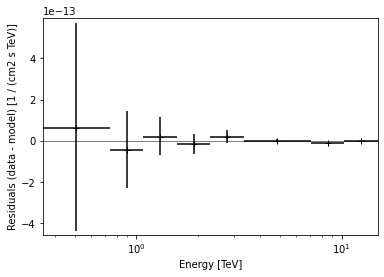

In [21]:
flux_points_joint_dataset.plot_residuals();

In [22]:
%%time
# REPEAT FOR STACK
# Defining the energy edges
energy_edges = list(spectrum["E"])*u.TeV

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=source)

flux_points_stacked = fpe.run(datasets=[stacked])





CPU times: user 4.19 s, sys: 32.1 ms, total: 4.22 s
Wall time: 4.22 s


In [ ]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_stacked["is_ul"] = flux_points_stacked.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_stacked.plot(energy_power=2, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_stacked.to_sed_type("dnde").plot_ts_profiles(ax=ax);

'\nax_spectrum = flux_points_stacked.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Stacked Data")\nplot_spectrum(ax=ax_spectrum,model=stacked_model , result=result_stacked, label="Best Fit Stacked", color="darkorange")\nax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], xerr=spectrum["dNdE_errl"], yerr=spectrum["dNdE_erru"], fmt="o",label="ED Data")\nax_spectrum.set_xlim([0.15, 35])\nax_spectrum.legend()\n'

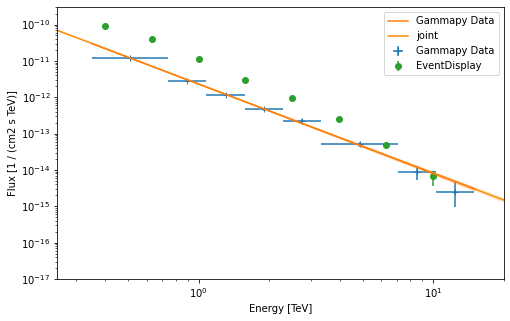

In [23]:
plt.figure(figsize=(8,5))
# Below is the same thing as above, but with the dataset, you've got a bigger range of plot. Like the residuals plot next run box
flux_points_stacked_dataset= FluxPointsDataset(data=flux_points_stacked,models=stacked_model)
ax_spectrum = flux_points_stacked_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label="Gammapy Data");


# The Stacked fit
plot_spectrum(ax=ax_spectrum, model=stacked_model , result=result_stacked, label="joint", color="darkorange")


# For the ED DATA
ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

# # DEFINIE THE AXIS BOUNDARY WITH ax (not plt)
ax_spectrum.set_xlim([0.25, 20])
ax_spectrum.set_ylim([1e-17, 3e-10])



plt.legend()

"""
ax_spectrum = flux_points_stacked.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Stacked Data")
plot_spectrum(ax=ax_spectrum,model=stacked_model , result=result_stacked, label="Best Fit Stacked", color="darkorange")
ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], xerr=spectrum["dNdE_errl"], yerr=spectrum["dNdE_erru"], fmt="o",label="ED Data")
ax_spectrum.set_xlim([0.15, 35])
ax_spectrum.legend()
"""

EXTRACTING THE LIGHT CURVE ESTIMATOR:

Note how we will proceed:

Analysing the light curve run-by-run (**doc 11**)... (Not useful, because you got like 100 runs).

Analysing the light curve night-by-night (**doc 11**)-> This is what you should do normally, but there is like 100 runs, so not sure this will work that well.

On the two aboves steps, it would be interesting to note about the variability of the source; more especially in terms of period of flaring. That is how "powerful" the flaring is.

Analysing the Light Curve into 4-weeks binning. The 4-weeks is used here, because that's what is used in ED, but naturally, you can set the time interval to anything (as we see in the night-by-night doc.

Also, we will look for the points with the highest flux (pick the 4th highest points) and we will look at the day time interval for each points. The purpose of this will be to check if there is any intraday variability of the flux for these runs...

Since we don't have the chi-squared, it would be interesting to stimulate a flux given the model we provide of the source. We will follow (**doc 13**) here.


If we are lucky, we could also model a temporal fit to map the flaring episodes that occurs.

In [24]:
%%time
# RUN-BY-RUN

#Step1: Create the light curve maker using the LightCurveEstimator
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=True)

lc_1d = lc_maker_1d.run(list_of_dataset)





CPU times: user 1min 52s, sys: 680 ms, total: 1min 53s
Wall time: 1min 53s


In [25]:
lc_1d.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
54414.12966745328,54414.14358604182,8.0,2.29128784747792,0.3499999999999999,15.0,2.81692233809797e-13,6.772651730436638e-12,6.249317442017989e-12,1.4788842275014342e-12,0.5275263696967158,4.771425740409585,True,0.43670340071368324,1.658010643045607,0.5272324380942705,0.38903014823021626,1.7555869182211357,0.20000000000000004 .. 5.000000000000001,5.511674981584255 .. 30.740341169327415,1.2876376210120637,1.486000814734407e-13,4.945352006409691e-13,1.2301595645937232e-13,1.4851728322376056e-13,1.0958677147432607e-13,3.5727523805774202e-12,1.1889978779622298e-11,2.9576400425310913e-12,3.5707616842014883e-12,2.6347657066033958e-12
54417.06870762346,54417.08262638941,15.0,2.29128784747792,0.3499999999999999,15.0,2.81692233809797e-13,6.772651730436638e-12,6.249317442017989e-12,1.4788842275014342e-12,0.5794764459860744,9.683131205215128,True,0.6383591179491281,1.0456815008998372,0.711944636241408,0.5681259006025168,2.1543066358832217,0.20000000000000004 .. 5.000000000000001,10.092793649946861 .. 29.994836895803104,1.022585693670627,1.6323401450997946e-13,6.068514485732137e-13,1.7982080590794158e-13,2.0054927493174558e-13,1.6003665402592566e-13,3.9245921546548595e-12,1.4590368565405634e-11,4.323383984818168e-12,4.821753072615455e-12,3.8477188638215085e-12
54420.06785549179,54420.08177221662,3.0,2.29128784747792,0.3499999999999999,15.0,2.81692233809797e-13,6.772651730436638e-12,6.249317442017989e-12,1.4788842275014342e-12,1.8521357560530305e-05,6.134876484654158,True,0.003170478925577416,-7.279761041978361e-06,0.0028647384242503904,0.0028647384242503904,0.9815161021906154,0.20000000000000004 .. 5.000000000000001,6.453715312931324 .. 41.62051791771514,nan,5.217322584415754e-18,2.764854633463594e-13,8.930992907927874e-16,8.069745660078504e-16,8.069745660078504e-16,1.2543870433236126e-16,6.6474667279526946e-12,2.1472549581624776e-14,1.9401875646247732e-14,1.9401875646247732e-14
54420.082682742286,54420.09660077975,11.0,2.29128784747792,0.3499999999999999,15.0,2.81692233809797e-13,6.772651730436638e-12,6.249317442017989e-12,1.4788842275014342e-12,1.0437647001526784,4.239406638802544,True,0.6424300829599783,3.954541564347805,0.7075223219649663,0.581455561404709,2.5954661751003716,0.20000000000000004 .. 5.000000000000001,6.593932700588152 .. 22.111453663033362,1.988602917715803,2.9402040995782097e-13,7.311226646417934e-13,1.809675651356095e-13,1.9930354334460576e-13,1.6379151595322207e-13,7.069054802657716e-12,1.7578188482083294e-11,4.3509552130434495e-12,4.7918022781785776e-12,3.937996014119609e-12
54421.09222567843,54421.10614294161,15.0,2.29128784747792,0.3499999999999999,15.0,2.81692233809797e-13,6.772651730436638e-12,6.249317442017989e-12,1.4788842275014342e-12,2.159521119465353,8.227977500671013,True,0.8447902080477582,15.551028487366505,0.925025768063679,0.7656518159520912,4.173211794147987,0.20000000000000004 .. 5.000000000000001,19.41836505074393 .. 15.371229172197028,3.9434792363300843,6.083203281016288e-13,1.175561352454937e-12,2.3797084080561615e-13,2.605725749374809e-13,2.1567817035607213e-13,1.4625684446661487e-11,2.8263710079114947e-11,5.721469864390577e-12,6.264877368774955e-12,5.1854930962198845e

In [26]:
# FOR THE DATA OF ED

# There is some runs with a flux of -999.0 in the lightcurve of ED that need to be removed:
time_ED = list(lightcurve["MJD"])
time_err_ED = list(lightcurve["MJD_err"])
flux_ED = list(lightcurve["Flux"])
flux_err_ED = list(lightcurve["Flux_err"])

bad_runs_id = []
for i, flux in enumerate(flux_ED):
    if abs(flux)> 1:
        bad_runs_id.append(i)

        
x_axis_lc = []
x_axis_err_lc = []
y_axis_lc = []
y_axis_err_lc=[]
mean_y_axis_lc = 0
for i in range(len(time_ED)):
    if i in bad_runs_id:
        continue
    else:
        x_axis_lc.append(time_ED[i])
        x_axis_err_lc.append(time_err_ED[i])
        y_axis_lc.append(flux_ED[i])
        y_axis_err_lc.append(flux_err_ED[i])
        mean_y_axis_lc += flux_ED[i]
mean_y_axis_lc = mean_y_axis_lc / len(y_axis_lc) 
       
        
    
    

    

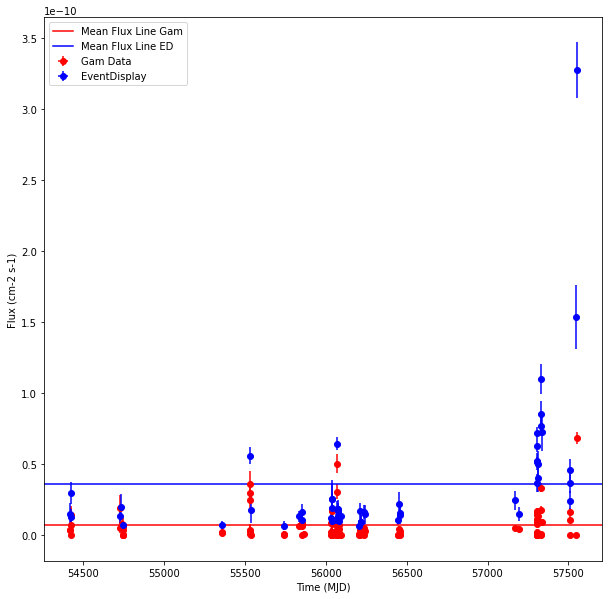

In [27]:
# GAMMAPY
plt.figure(figsize=(10,10))
ax = lc_1d.plot(marker="o", color="red", label="Gam Data")
plt.axhline(y=lc_1d.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

# FOR ED
plt.errorbar(x=x_axis_lc, y=y_axis_lc, xerr=x_axis_err_lc, yerr=y_axis_err_lc,fmt="o",label="EventDisplay", color="blue")
ax.axhline(y=mean_y_axis_lc, color="blue", label="Mean Flux Line ED")
plt.legend()
# THERE ARE LESS RUNS IN ED DATA, but yes in general ED data are larger. Might have something to do with the total counts

In [ ]:
# NIGHT-BY-NIGHT 


# Step 1 is that we find the initial time and final time of the observations
# Step 2 is that we create the time_interval into separate night

if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 1
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)

In [ ]:
%%time
lc_maker_1d.time_intervals=time_intervals

nightwise1_lc = lc_maker_1d.run(list_of_dataset)

In [ ]:
ax = nightwise1_lc.plot(marker="o", label="1D", color="red")
plt.axhline(y=nightwise1_lc.table["flux"].mean(), color="red")

In [ ]:
time_start= list(lc_1d.table["time_min"])[0]
time_end = list(lc_1d.table["time_max"])[-1]



# np.arange is a semi-open so np.arange(0, 6, 2) -> [0, 2, 4] (not the 6)

# First we need to find the exact value that will allow us to increment 

time_list = np.arange((time_start), (time_end)+1, 1)
# Making sure the ending starting values of the time_integrals will differ
"""
i = 2
while i < len(time_list):
    time_list[i]+= 0.0000001
    i += 2
"""
time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_list[:-1], time_list[1:])]

# Removing some no good time intervals in between

no_good_time_intervals = []
for tstart, tstop in zip(list(lc_1d.table["time_max"])[:-1], list(lc_1d.table["time_min"])[1:]):
    no_good_time_intervals.append([tstart, tstop]) 

for index, time_int in enumerate(time_intervals):
    for no_good_int in no_good_time_intervals:
        if (float(time_int.value[0]) > float(no_good_int[0])) and (float(time_int.value[1]) < float(no_good_int[1])):
            del time_intervals[index]
            

print(len(time_intervals))


In [ ]:
%%time
nightwise_observations = observations.select_time(time_intervals)


In [ ]:
%%time
lc_maker_1d.time_intervals=time_intervals

nightwise_lc = lc_maker_1d.run(list_of_dataset)


In [ ]:
ax = nightwise_lc.plot(marker="o", label="1D")
plt.axhline(y=nightwise_lc.table["flux"].mean(), color="red")

In [ ]:
nightwise_lc.table["time_min","time_max", "flux"]
nightwise_lc.table

Ok, here we need to find the intra-day variability of the flux during a flare period. Here, we take the highest point flux, because we expect that this point (being the most intense flux) will have the highest fluctuations. 

However, we note that the problem we have here is that there is only one observation that is within the time integral we set, which produces only 4 observations when we pass it throught the filter. That's just not enough.


In [ ]:
%%time
#Identify the largest value of the flux:


flux_list = list(lc_1d.table["flux"])
time_min_list = list(lc_1d.table["time_min"])
time_max_list = list(lc_1d.table["time_max"])
max_value = max(flux_list)
index = flux_list.index(max_value)
time_start = time_min_list[index]
livetime = time_edge[1]-time_edge[0]
new_obs_id = []
for obs in observations:
    if (obs.gti.time_start.value >= (time_start-2)) and (obs.gti.time_stop.value<=(time_start+3)):
        new_obs_id.append(obs.obs_id)
new_observations = data_store.get_observations(new_obs_id)
print(new_observations)
for obs in new_observations:
    print(obs.gti)
    


#print(index)
"""
# For the second value:
flux_list.pop(index)
max_value = max(flux_list)
index = flux_list.index(max_value)
time_edge.append(time_min_list[index])
time_edge.append(time_max_list[index])
"""

# Creating the time interval:
# We break it up into 8 min bins for a total duration of 240 min (30 bins). 
duration = 2 * u.min
n_time_bins = 100

time_list = Time(time_start, format="mjd", scale="utc")+np.arange(n_time_bins+1)*duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(time_list[:-1], time_list[1:])]
"""
# Prevent the overlap between time_intervals.
for el in time_intervals:
    el[0] -= 0.0000001
"""

print(time_intervals)

filt_observations = new_observations.select_time(time_intervals)





In [ ]:
print(filt_observations)

In [ ]:
filt_list_datasets = Datasets()
for obs in filt_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset = safe_mask_masker.run(dataset, obs)
    filt_list_datasets.append(dataset)
    


In [ ]:
for dataset in filt_list_datasets:
    dataset.models = sky_model

In [ ]:
list_dataset = Datasets()
for obs in filt_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    #dataset = bkg_maker.run(dataset, obs)
    #dataset = safe_mask_maker.run(dataset, obs)
    #dataset.models = Models(sky_model)
    list_dataset.append(dataset)
    print(dataset)


In [ ]:
target_position = filt_observations[0].pointing_radec
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
background_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)
DATASETS = Datasets()
for obs in filt_observations:    
    dataset = maker.run(dataset_empty.copy(), obs)
    #dataset_on_off = bkg_maker.run(dataset, obs)
    #dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    #DATASETS.append(dataset_on_off)
    print(dataset)

In [ ]:
%%time
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=True, time_intervals=time_intervals)
#lc_maker_1d.time_intervals = time_intervals
lc_day = lc_maker_1d.run(list_dataset)



In [ ]:
lc_day.table

In [ ]:
lc_day.plot(marker="o")

**What we observe in the plot above is worthless**

Conclusion is that there is not enough observations that has been made in order to take any conclusion on this. The issues is that there is no 2+ different flaring observations (by observations, I mean the observation we import from the FITS) that are close to one another, so basically when you apply your time_bin you only got 6/7 new sub_observations, which is not enough to make any form of conclusion...




Another thing that is available to do with ED is 4-weeks Light_Curve time_bins. So we'll do that

In [93]:
%%time
# 4 weeks:
if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 28
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)

[<Time object: scale='utc' format='mjd' value=[[54414.12891301]
 [54442.12891301]]>, <Time object: scale='utc' format='mjd' value=[54737. 54765.]>, <Time object: scale='utc' format='mjd' value=[55532. 55560.]>, <Time object: scale='utc' format='mjd' value=[56034. 56062.]>, <Time object: scale='utc' format='mjd' value=[56064. 56092.]>, <Time object: scale='utc' format='mjd' value=[56094. 56122.]>, <Time object: scale='utc' format='mjd' value=[56204. 56232.]>, <Time object: scale='utc' format='mjd' value=[56238. 56266.]>, <Time object: scale='utc' format='mjd' value=[56447. 56475.]>, <Time object: scale='utc' format='mjd' value=[57171. 57199.]>, <Time object: scale='utc' format='mjd' value=[57303. 57331.]>, <Time object: scale='utc' format='mjd' value=[57331. 57359.]>, <Time object: scale='utc' format='mjd' value=[57510. 57538.]>, <Time object: scale='utc' format='mjd' value=[57546. 57574.]>]
CPU times: user 166 ms, sys: 18.7 ms, total: 184 ms
Wall time: 187 ms


In [91]:
%%time
# 4 weeks:
time_start = observations[0].gti.time_start
time_end = observations[-1].gti.time_stop
#print(time_end)
time = float(time_start.value)
time_intervals = []



#print(type(observations[1].gti.time_start.value))
count = 0
while time < (float(time_end.value)):
    t_plus_one = time + 28
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    for i in range(count, len(observations), 1):
        count +=1
        if float(observations[i].gti.time_start.value) > (t_plus_one+1):
            time = observations[i].gti.time_start.value
            count = i-1
            break
print(time_intervals)



[<Time object: scale='utc' format='mjd' value=[54414.12891301 54442.12891301]>, <Time object: scale='utc' format='mjd' value=[54737. 54765.]>, <Time object: scale='utc' format='mjd' value=[55532. 55560.]>, <Time object: scale='utc' format='mjd' value=[56034. 56062.]>, <Time object: scale='utc' format='mjd' value=[56064. 56092.]>, <Time object: scale='utc' format='mjd' value=[56094. 56122.]>, <Time object: scale='utc' format='mjd' value=[56204. 56232.]>, <Time object: scale='utc' format='mjd' value=[56238. 56266.]>, <Time object: scale='utc' format='mjd' value=[56447. 56475.]>, <Time object: scale='utc' format='mjd' value=[57171. 57199.]>, <Time object: scale='utc' format='mjd' value=[57303. 57331.]>, <Time object: scale='utc' format='mjd' value=[57331. 57359.]>, <Time object: scale='utc' format='mjd' value=[57510. 57538.]>]
CPU times: user 1.55 s, sys: 68.2 ms, total: 1.62 s
Wall time: 1.7 s


In [ ]:
%%time
lc_maker_1d.time_intervals=time_intervals

four_week_lc = lc_maker_1d.run(list_of_dataset)



In [ ]:
ax = four_week_lc.plot(marker="o", label="1D")
plt.axhline(y=four_week_lc.table["flux"].mean(), color="red")

In [ ]:
four_week_lc.table

We will now analyse the flux year-by-year. Our data go from 2007 to 2016 (Check the gti).

In [ ]:
#Time_intervals for each year
time_2007 = Time(["2007-01-01T00:00", "2007-12-31T23:59"]).mjd
print(time_2007)
time_2008 = Time(["2008-01-01T00:00", "2008-12-31T23:59"]).mjd
time_2009 = Time(["2009-01-01T00:00", "2009-12-31T23:59"]).mjd
time_2010 = Time(["2010-01-01T00:00", "2010-12-31T23:59"]).mjd
time_2011 = Time(["2011-01-01T00:00", "2011-12-31T23:59"]).mjd
time_2012 = Time(["2012-01-01T00:00", "2012-12-31T23:59"]).mjd
time_2013 = Time(["2013-01-01T00:00", "2013-12-31T23:59"]).mjd
time_2014 = Time(["2014-01-01T00:00", "2014-12-31T23:59"]).mjd
time_2015 = Time(["2015-01-01T00:00", "2015-12-31T23:59"]).mjd
time_2016 = Time(["2016-01-01T00:00", "2016-12-31T23:59"]).mjd

In [ ]:
time_2007 = np.linspace(time_2007[0], time_2007[-1], 12)
time_2007[0] = time_2007[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2007[:-1], time_2007[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2007
lc_maker_1d.time_intervals=time_intervals

lc_2007 = lc_maker_1d.run(list_of_dataset)
lc_2007.plot(marker="o")

In [ ]:
time_2008 = np.linspace(time_2008[0], time_2008[-1], 12)
time_2008[0] = time_2008[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2008[:-1], time_2008[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2008
lc_maker_1d.time_intervals=time_intervals

lc_2008 = lc_maker_1d.run(list_of_dataset)
lc_2008.plot(marker="o")

In [ ]:
time_2009 = np.linspace(time_2009[0], time_2009[-1], 2)
time_2009[0] = time_2009[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2009[:-1], time_2009[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2009
lc_maker_1d.time_intervals=time_intervals

lc_2009 = lc_maker_1d.run(list_of_dataset)
lc_2009.plot(marker="o")

In [ ]:
time_2010 = np.linspace(time_2010[0], time_2010[-1], 12)
time_2010[0] = time_2010[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2010[:-1], time_2010[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2010
lc_maker_1d.time_intervals=time_intervals

lc_2010 = lc_maker_1d.run(list_of_dataset)
lc_2010.plot(marker="o")

No handles with labels found to put in legend.


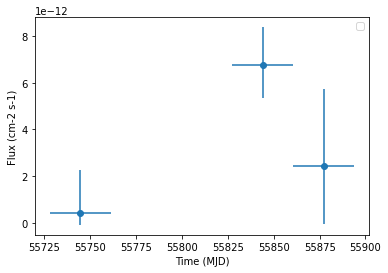

In [251]:
time_2011 = np.linspace(time_2011[0], time_2011[-1], 12)
time_2011[0] = time_2011[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2011[:-1], time_2011[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2011
lc_maker_1d.time_intervals=time_intervals

lc_2011 = lc_maker_1d.run(list_of_dataset)
lc_2011.plot(marker="o")

No handles with labels found to put in legend.


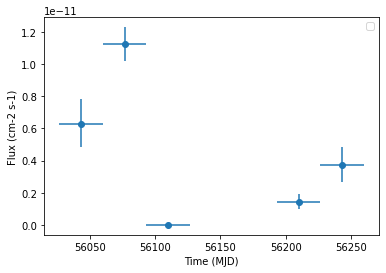

In [252]:
time_2012 = np.linspace(time_2012[0], time_2012[-1], 12)
time_2012[0] = time_2012[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2012[:-1], time_2012[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2012
lc_maker_1d.time_intervals=time_intervals

lc_2012 = lc_maker_1d.run(list_of_dataset)
lc_2012.plot(marker="o")

No handles with labels found to put in legend.


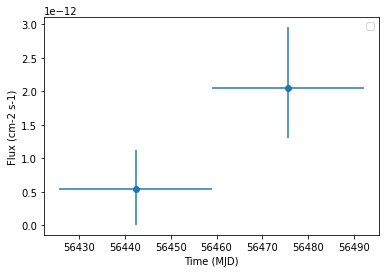

In [253]:
time_2013 = np.linspace(time_2013[0], time_2013[-1], 12)
time_2013[0] = time_2013[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2013[:-1], time_2013[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2013
lc_maker_1d.time_intervals=time_intervals

lc_2013 = lc_maker_1d.run(list_of_dataset)
lc_2013.plot(marker="o")

In [113]:
time_2014 = np.linspace(time_2014[0], time_2014[-1], 12)
time_2014[0] = time_2014[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2014[:-1], time_2014[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2014
lc_maker_1d.time_intervals=time_intervals

lc_2014 = lc_maker_1d.run(list_of_dataset)
lc_2014.plot(marker="o")

ValueError: LightCurveEstimator: No datasets in time intervals

No handles with labels found to put in legend.


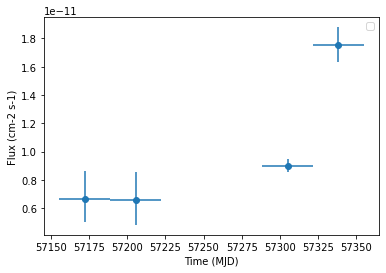

In [255]:
time_2015 = np.linspace(time_2015[0], time_2015[-1], 12)
time_2015[0] = time_2015[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2015[:-1], time_2015[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2015
lc_maker_1d.time_intervals=time_intervals

lc_2015 = lc_maker_1d.run(list_of_dataset)
lc_2015.plot(marker="o")

No handles with labels found to put in legend.


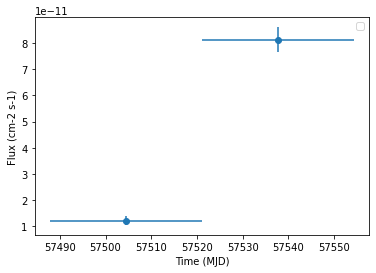

In [114]:
time_2016 = np.linspace(time_2016[0], time_2016[-1], 12)
time_2016[0] = time_2016[0]-0.000001

time_intervals = [Time([tstart, tstop], format="mjd", scale="utc") for tstart, tstop in zip(time_2016[:-1], time_2016[1:])]

# Prevent the overlap between time_intervals.
for el in time_intervals:
    el += 0.000001
# Flux for 2016
lc_maker_1d.time_intervals=time_intervals

lc_2016 = lc_maker_1d.run(list_of_dataset)
lc_2016.plot(marker="o")

In [257]:
# THIS IS THE HIGH-STATE SOURCE

In [74]:
obs_id_flares = [38018,
38019,
41470,
53469,
53470,
53471,
53472,
53473,
53535,
62046,
62162,
58003,
62672,
62673,
62674,
62675,
62676,
62677,
62695,
62697,
78572,
78573,
78574,
78576,
78596,
78597,
78598,
78599,
78613,
78614,
78615,
78616,
78647,
78648,
78664,
78666,
78705,
78760,
79008,
79009,
79051,
79082,
79107,
81868,
81891,
82417,
82514,
78793,
78817,
82579]

flare_obs_list = []
for id_fla in obs_id_flares:
    for i, obs_ide in enumerate(list(observations.ids)):
        if id_fla == int(obs_ide):
            flare_obs_list.append(observations[i])
            

            

            
            
        

In [75]:
%time
flare_datasets = Datasets()
count = 0
for obs in flare_obs_list:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    flare_datasets.append(dataset)
    stacked.stack(dataset)
    count+=1
# Making sure all the datasets are in the list
print(count==len(flare_obs_list))
    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
True


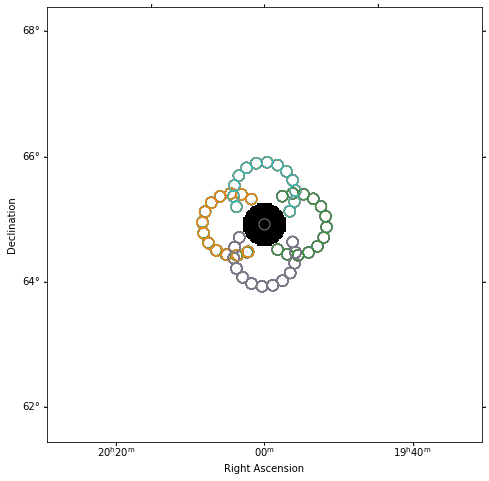

In [76]:
plt.figure(figsize=(8,8))
_, ax, _ = exclusion_mask.plot()

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="grey")
plot_spectrum_datasets_off_regions(ax=ax, datasets=list_of_dataset)

In [77]:
%%time
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.67, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")


for dataset in flare_datasets:
    dataset.models = Models([sky_model])
    
    
# Performing a joint fit of the model:
fit_joint_flare = Fit(flare_datasets)
result_joint_flare = fit_joint_flare.run()
result_joint_flare.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.5059e+00,,nan,nan,False,5.706e-02
amplitude,3.5926e-12,cm-2 s-1 TeV-1,nan,nan,False,1.180e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [78]:
%%time
lc_maker_flare = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=False)

lc_flare = lc_maker_flare.run(flare_datasets)

CPU times: user 53.5 s, sys: 530 ms, total: 54.1 s
Wall time: 59.6 s


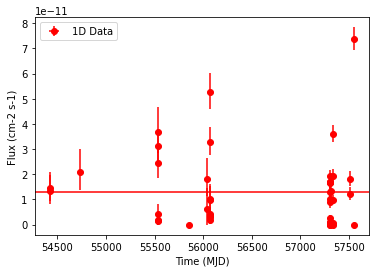

In [79]:
ax = lc_flare.plot(marker="o",color="red", label="1D Data")
plt.axhline(y=lc_flare.table["flux"].mean(), color="red")



In [264]:
# Low-State

In [67]:
obs_id_noF = [37793,
37890,
37991,
37992,
41472,
41478,
41713,
41960,
41961,
41962,
41963,
41964,
42073,
53504,
61991,
61992,
61993,
62015,
62016,
62017,
62018,
62082,
62109,
62137,
51601,
51602,
57377,
57379,
57857,
58002,
58026,
58279,
62596,
62720,
62748,
62773,
62793,
62822,
62884,
62917,
62993,
62994,
63006,
63171,
63722,
63723,
63767,
63854,
63928,
63998,
64085,
64182,
64518,
64643,
64694,
68985,
68986,
69022,
69068,
69140,
69192,
69233,
77945,
78168,
81841,
70031,
70032,
74392,
74394]

noF_obs_list = []
for id_no_fla in obs_id_noF:
    for i, obs_ide in enumerate(list(observations.ids)):
        if id_no_fla == int(obs_ide):
            noF_obs_list.append(observations[i])
            

            

            
            
        

In [68]:
%time
noF_datasets = Datasets()
count = 0
for obs in noF_obs_list:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    noF_datasets.append(dataset)
    stacked.stack(dataset)
    count+=1
# Making sure all the datasets are in the list
print(count==len(noF_datasets))
    

CPU times: user 7 µs, sys: 13 µs, total: 20 µs
Wall time: 50.1 µs
True


In [69]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.67, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")


for dataset in noF_datasets:
    dataset.models = Models([sky_model])
    
    
# Performing a joint fit of the model:
fit_joint_noF = Fit(noF_datasets)
result_joint_noF = fit_joint_noF.run()
result_joint_noF.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.2392e+00,,nan,nan,False,2.343e-01
amplitude,5.6516e-13,cm-2 s-1 TeV-1,nan,nan,False,7.930e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [70]:
lc_maker_noF = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=False)

lc_noF = lc_maker_noF.run(noF_datasets)

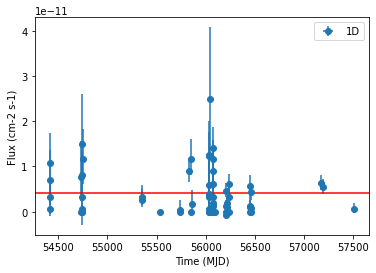

In [71]:
ax = lc_noF.plot(marker="o", label="1D")
plt.axhline(y=lc_noF.table["flux"].mean(), color="red")



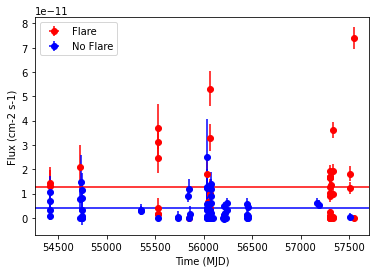

In [88]:

ax = lc_flare.plot(marker="o", label="Flare", color="red")
plt.axhline(y=lc_flare.table["flux"].mean(), color="red")
#help(plt.plot)
lc_noF.plot(marker="o", color="blue", label="No Flare")
#plt.scatter(list(lc_noF.table["time_min"]), list(lc_noF.table["flux"]), color="blue",marker="o",label="No Flare")
plt.axhline(y=lc_noF.table["flux"].mean(), color="blue")
plt.legend()

In [117]:
target_position = SkyCoord.from_name("2HWC J1953+294")
print(target_position)
target_position = SkyCoord.from_name("HESS J1943+213")
print(target_position)
target_position = SkyCoord.from_name("HESS J1943+213")

<SkyCoord (ICRS): (ra, dec) in deg
    (298.26, 29.48)>
<SkyCoord (ICRS): (ra, dec) in deg
    (295.98416667, 21.306375)>
